Unprecedented is a word often used in the context of the economic
data being generated in the post-COVID world, but are there historical
episodes that may be useful in serving as guide in terms of thinking 
about near-term job losses after the initial shock observed in late March.
What could the path of initial claims be over the next few months, and what
should we expect in terms of the total number of claims during thi period?

In [Bram & Deitz](https://libertystreeteconomics.newyorkfed.org/2020/04/the-coronavirus-shock-looks-more-like-a-natural-disaster-than-a-cyclical-downturn.html) an interesting idea to answer this question is explored
--- that the COVID shock to labor markets is more akin to a natural disaster like
hurricane Katrina or Maria, rather than a classic recession-induced
hit to employment. As they correctly point out

> Recessions typically develop gradually over time, reflecting underlying 
  economic and financial conditions, whereas the current economic situation
  developed suddenly as a consequence of a fast-moving global pandemic.
  A more appropriate comparison would be to a regional economy suffering 
  the effects of a severe natural disaster, like Louisiana after Hurricane 
  Katrina or Puerto Rico after Hurricane Maria. To illustrate this point, we 
  track the recent path of unemployment claims in the United States, finding a 
  much closer match with Louisiana after Katrina than the U.S. economy 
  following the Great Recession.

While the national scope of the COVID shock is clearly different and unprecedented,
there are similarities with natural disasters which by their nature, tend to 
be more localized. As such, they can provide insights into the way labor markets
evolve in the short-run. We do this by estimating exponential decay models for
different episodes, both natural-disaster related or recession-driven, and 
calibrate the parameters of this process to the historical data on claims.

## The model

We turn to this question by building a model for capturing short-term dynamics in
a COVID world.

To be precise, we posit that initial claims, normalized to their peak
value during each episode, follow:

\begin{equation}
\label{eqn:ic_process}
y_{t} = A \exp(-\kappa x^{\beta})\epsilon_{t}
\end{equation}
where $x$ is the number of weeks from the peak of initial claims
during the episode and $\epsilon_{t} \sim \mathcal{LN}(0,\, \sigma_{y})$%
(*Estimating the model in logarithms linearizes it and
makes the right-hand side additive.*). 
The parameter $A$ is normalized to 1, so we just have the
2 parameters $\kappa$ and $\beta$ to estimate. We go further and 
specify episode-specific parameters that drive this process, so
these become $\kappa_{j}$ and $\beta_{j}$ where $j$ is an 
episode-specific index. The smaller the $\kappa$ parameter,
the longer it takes for the iniital shock to claims to taper down.

In [1]:
import joblib
import datetime

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
import pandas as pd
import numpy as np
import pytoml

from fredapi import Fred
import us

In [4]:
RANDOM_SEED = 8924
np.random.seed(286)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

In [6]:
plt.rcParams.update({
    "font.family": "Source Sans Pro",
    "font.serif": ["Source Sans Pro"],
    "font.sans-serif": ["Source Sans Pro"],
    "font.size": 10,
})

In [7]:
import pymc3 as pm
import arviz as az
pm.__version__, az.__version__

('3.9.1', '0.9.0')

In [8]:
START_DATE = datetime.date(1995, 1, 1)
with open("/home/gsinha/.config/gcm/gcm.toml") as f:
    config = pytoml.load(f)
FRED_API_KEY = config["api_keys"]["fred"]

In [9]:
states = [x.abbr for x in us.STATES] + ["DC"]

In [10]:
fred = Fred(api_key=FRED_API_KEY)

labor_df = pd.DataFrame(
    1.0e3*pd.Series(fred.get_series("PAYEMS"), name="nfp")
).reset_index().rename(columns={"index": "medate"})
labor_df["medate"] += pd.tseries.offsets.MonthEnd(0)

In [11]:
series = ["ICSA", "LAICLAIMS", "PRIICLAIMS", "NJICLAIMS"]
df = []
for v in series:
    x =  pd.Series(
        fred.get_series(v, observation_start=START_DATE), name=v
    )
    df.append(x)

y_ts = pd.concat(df, axis=1)
y_ts.columns = ["US", "LA", "PR", "NJ"]

In [12]:
def make_data(episode):
    ''' make dataframe from FRED data '''
    
    shock_dates_dict = {
        "Katrina": ["2005-09-17", "2005-12-31", "LA"],
        "Maria": ["2017-11-04", "2018-03-31", "PR"],
        "Sandy": ["2012-11-10", "2013-05-11", "NJ"],
        "GFC": ["2009-03-28", "2010-06-30", "US"],
        "9/11": ["2001-09-29", "2002-02-26", "US"],
        "COVID": ["2020-03-28", None, "US"]
    }

    start_date = shock_dates_dict[episode][0]
    end_date = shock_dates_dict[episode][1]
    state = shock_dates_dict[episode][2]
    
    X_ic = y_ts.loc[start_date:end_date, state].reset_index()
    data = pd.DataFrame.from_dict(
        {
            "episode": [episode] * X_ic.shape[0],
            "x": (X_ic[state]/X_ic.iat[0, 1]).index,
            "y": (X_ic[state]/X_ic.iat[0, 1]).values,
            "ic": X_ic[state].values,
            "obsdate": X_ic["index"]
        }
    )
    
    return data

In [13]:
df  = []
for i in ["Katrina", "Maria", "Sandy", "COVID", "GFC", "9/11"]:
    df.append(make_data(i))
data = pd.concat(df)

In [14]:
epi_enc = LabelEncoder()
epi_enc.fit(data.episode)

LabelEncoder()

In [15]:
data["epi_idx"] = epi_enc.transform(data.episode)
n_epi = data.epi_idx.max() + 1

In [16]:
def hierarchical_normal(name, shape, μ=0., sigma=10.0):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.HalfNormal('σ_{}'.format(name), sigma=sigma)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [17]:
with pm.Model() as ic_model:
    x = pm.Data("x", data.x)
    y = pm.Data('y', data.y)
    
    #μ_k = pm.Normal("μ_k", mu=0, sigma=5.)
    σ_κ = pm.HalfCauchy("σ_κ", beta=1.)
    κ = pm.HalfNormal("κ", sigma=σ_κ, shape=n_epi)
    
    μ_α = pm.HalfNormal("μ_α", sigma=0.25)
    μ_β = pm.HalfNormal("μ_β", sigma=0.25)

    β = pm.Beta("β", alpha=μ_α, beta=μ_β)
    #β = pm.distributions.GaussianRandomWalk(
    #    "β", mu=μ_β, sigma=1, shape=data.x.max() + 1
    #)
    
    σ_y = pm.HalfCauchy("σ_y", beta=5.)
    mu = pm.Deterministic("mu", -κ[data.epi_idx]*(x**(β)))
    
    # likelihood
    yobs = pm.Lognormal("yobs", mu=mu, sigma=σ_y, observed=y)

In [18]:
with ic_model:
    trace = pm.sample(
        2000, tune=1000, random_seed=RANDOM_SEED, target_accept=0.95,
        init="advi+adapt_diag"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 26600
Interrupted at 26,599 [13%]: Average Loss = 61.297
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_y, β, μ_β, μ_α, κ, σ_κ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
with ic_model:
    ppc = pm.sample_posterior_predictive(trace)

In [20]:
az_data = az.from_pymc3(
    trace=trace, posterior_predictive=ppc, model=ic_model,
    coords={"episodes": epi_enc.classes_},
    dims={"κ": ["episodes"]}
)

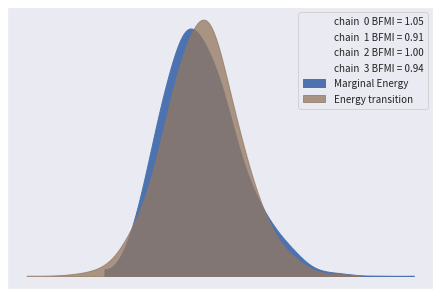

In [21]:
az.plot_energy(az_data, figsize=(6, 4));

In [22]:
vnames = ["κ", "β", "σ_y"]
sum_df = az.summary(az_data, var_names=vnames, round_to=3)
sum_df.index = ["κ: " + x for x in list(epi_enc.classes_)] + ["β", "σ_y"]
sum_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
κ: 9/11,0.029,0.007,0.017,0.042,0.000,0.000,4048.173,4048.173,3936.164,3919.639,1.001
κ: COVID,0.226,0.022,0.186,0.267,0.001,0.000,1760.725,1760.725,1733.753,3449.880,1.003
κ: GFC,0.017,0.003,0.012,0.022,0.000,0.000,1822.714,1822.714,1796.889,3579.906,1.003
κ: Katrina,0.397,0.035,0.329,0.462,0.001,0.001,1480.591,1480.591,1473.833,2738.421,1.004
κ: Maria,0.196,0.020,0.158,0.234,0.001,0.000,1498.671,1498.671,1489.298,2850.262,1.003
κ: Sandy,0.162,0.018,0.128,0.197,0.000,0.000,1457.959,1457.959,1440.594,2797.520,1.003
β,0.774,0.037,0.706,0.846,0.001,0.001,1417.254,1413.308,1422.677,2574.731,1.004
σ_y,0.187,0.011,0.169,0.208,0.000,0.000,6220.489,6148.896,6325.950,5015.764,1.000


## Estimates

In the Table above, we present the results of the exponential decay model. 
The $\kappa$ parameter ranges from a low of 0.02 during the Great Recession (GFC)
to a high of 0.4 in the aftermath of Katrina. The estimate for the current COVID
episode is in between the 2 but subject to considerable uncertainty given we
are still early in the process. As more data becomes available, 
the 95% credibility intervals will shrink but we have to be
cognizant of the fact that any projections will of necessity be
subject to fairly wide error bands. Regardless, the initial
results out of the gate suggest a pattern of behavior more in
line with natural disasters rather than the longer tapering
timeframes evidenced during and after recessions.

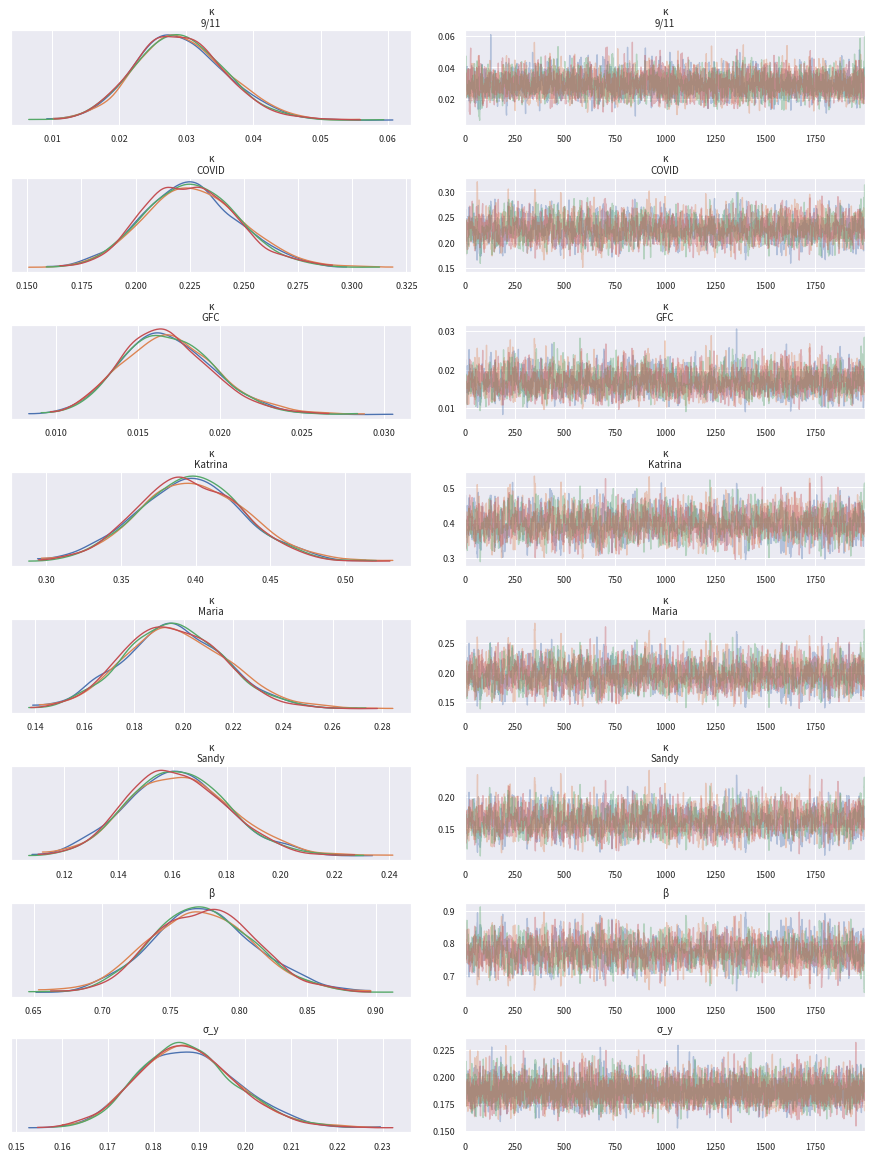

In [23]:
az.plot_trace(az_data, var_names=vnames);

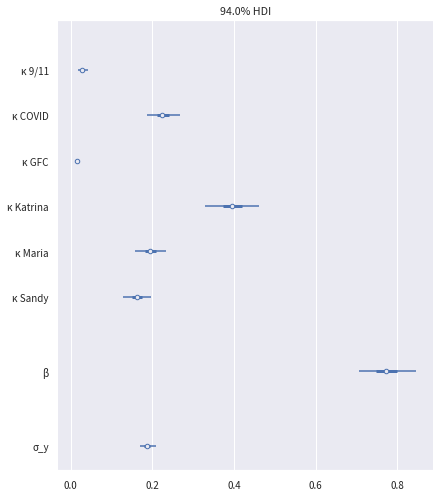

In [24]:
az.plot_forest(az_data, var_names=vnames, combined=True);

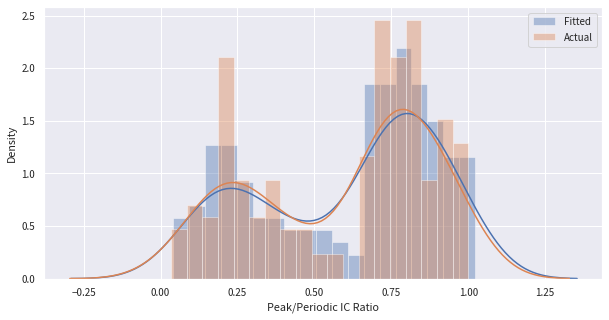

In [25]:
_, ax = plt.subplots(figsize=(10, 5))
sns.distplot(ppc["yobs"].mean(axis=0), bins=19, norm_hist=True, ax=ax, label="Fitted")
sns.distplot(data.y, bins=19, norm_hist=True, ax=ax, label="Actual")
ax.set(xlabel='Peak/Periodic IC Ratio', ylabel='Density')
plt.legend();

In [26]:
A = 0
κ = trace["κ"]
β = trace["β"]

## Fits

In the Figure below, we present the model predictions and
the associated 1 and 2 standard deviation ranges versus the observed data
on claims (relative to the peak) for each episode. Overall, the fits match
the historical experience quite well, except for the aftermath of Hurricane
Sandy where the initial data points come down much more sharply than the
model predictions. Note the relatively wide confidence bands for both 
the current "COVID" episode and the history of claims after 9/11.

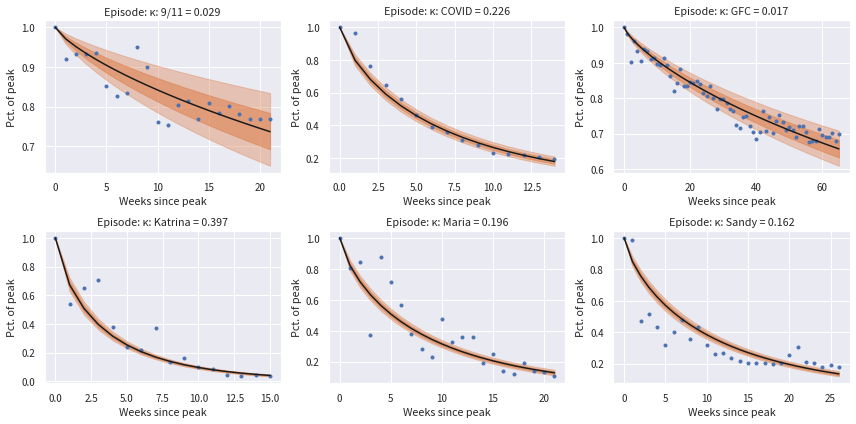

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, v in enumerate(["κ: " + x for x in epi_enc.classes_]):
    
    xx = data[data.epi_idx==i]["x"].values
    yy = data[data.epi_idx==i]["y"].values
    xx = xx.reshape((xx.max() + 1, 1))
    
    mu = A - κ[:, i].reshape(-1,1) * np.power(xx, β).T
    ic_hat_means = mu.mean(axis=0)
    ic_hat_se = mu.std(axis=0)
    
    j = i % 3
    l = 0 if i < 3 else 1
    ax[l, j].plot(xx, yy, 'C0.');
    ax[l, j].plot(xx, np.exp(ic_hat_means), c='k')

    ax[l, j].fill_between(
        xx[:, 0], np.exp(ic_hat_means + 1 * ic_hat_se),
        np.exp(ic_hat_means - 1 * ic_hat_se), alpha=0.6,
        color='C1'
    )
    ax[l, j].fill_between(
        xx[:, 0], np.exp(ic_hat_means + 2 * ic_hat_se),
        np.exp(ic_hat_means - 2 * ic_hat_se), alpha=0.4,
        color='C1'
    )
    ax[l, j].set_xlabel('Weeks since peak')
    ax[l, j].set_ylabel('Pct. of peak');
    ax[l, j].set_title(f'Episode: {v} = {sum_df.loc[v, "mean"]}');
    
fig.tight_layout()

In [28]:
def project_claims(state, covid_wt, sum_df, epi_enc, verbose=False):
    ''' get labor market data from STL '''
    
    def states_data(suffix, state, fred):
        ''' gets data from FRED for a list of indices '''

 
        idx = "ICSA" if state == "US" else state + suffix            
        x =  pd.Series(
                fred.get_series(
                    idx, observation_start=START_DATE), name=v
            )

        x.name = state

        return x    
    
    def forecast_claims(initval, initdate, enddate, covid_wt):
        ''' project initial claims '''
    
        μ_β = sum_df.loc["β", "mean"]
        μ_κ = sum_df.loc[["κ: COVID", "κ: Katrina"], "mean"].values
        μ_decay = covid_wt * μ_κ[0] + (1 - covid_wt) * μ_κ[1]
        
        dt_range = (
            pd.date_range(start=initdate, end=enddate, freq="W") - 
            pd.tseries.offsets.Day(1)
        )
        max_x = len(dt_range)
        
        w = np.arange(max_x)
        covid_idx = list(epi_enc.classes_).index("COVID")
        katrina_idx = list(epi_enc.classes_).index("Katrina")
        
        decay = covid_wt * κ[:, covid_idx] + (1 - covid_wt) * κ[:, katrina_idx]
        μ = np.exp(-decay * np.power(w.reshape(-1, 1), β))
        
        μ_df = pd.DataFrame(
            np.percentile(μ, q=[5, 25, 50, 75, 95], axis=1).T, 
            columns=["5th", "25th", "50th", "75th", "95th"]
        ) * initval
        μ_df["period"] = w
           
        ic = np.zeros(max_x)
        ic[0] = 1
        for j in np.arange(1, max_x, 1):
            ic[j] = np.exp(-μ_decay * np.power(j, μ_β))
        
        df = pd.concat(
            [
                pd.Series(np.arange(max_x), name="period"),
                pd.Series(ic, name="ic_ratio"),
                pd.Series(ic * initval, name="ic"),
                pd.Series((ic * initval).cumsum(), name="cum_ic")
            ], axis=1
        )
       
        df.index = dt_range
        μ_df.index = dt_range
    
        return df, μ_df
    
    fred = Fred(api_key=FRED_API_KEY)
    ic_raw = states_data("ICLAIMS", state, fred)

    init_value, init_date, last_date = (
        ic_raw[ic_raw.idxmax()], ic_raw.idxmax(), ic_raw.index[-1]
    )
    end_date  = (
        last_date + pd.tseries.offsets.QuarterEnd() + pd.tseries.offsets.DateOffset(months=3)
    )
    
    if verbose:
        print(
            f'State: {state}, {init_value}, {init_date}, {end_date}, {last_date}'
        )
    
    ic_fct, ic_pct = forecast_claims(init_value, init_date, end_date, covid_wt)
    ic_fct["state"] = state
    ic_pct["state"] = state
    
    return ic_raw, ic_fct, ic_pct, init_date, end_date

In [29]:
def claims_for_states():
    ''' generates claims forecast for state based on national '''

    pre_peak_claims_total = (
        sum([v["pre_peak_claims"] for k, v in sim_dict.items() if k != "US"])
    )
    claim_share = []
    for k, v in sim_dict.items():
        if k == "US":
            continue
        x = float(v["pre_peak_claims"])/pre_peak_claims_total
        y =  float(v["employed"])
        z = x * sim_dict["US"]["ic_pct"].iloc[:, :5].cumsum()/y
        z = z.iloc[-1].to_frame().T
        z["pct_low_risk"] = float(v["pct_low_risk"])
        z.index = [k]
        claim_share.append(z)
 
    return pd.concat(claim_share)

In [30]:
covid_wt = 1.0

In [31]:
ic_raw, fct_df, ic_pct, init_date, end_date = project_claims("US", covid_wt, sum_df, epi_enc, False)

In [32]:
fct_df

,period,ic_ratio,ic,cum_ic,state
2020-03-28,0,1.000000,6.867000e+06,6.867000e+06,US
2020-04-04,1,0.797718,5.477930e+06,1.234493e+07,US
2020-04-11,2,0.679457,4.665833e+06,1.701076e+07,US
2020-04-18,3,0.589234,4.046267e+06,2.105703e+07,US
2020-04-25,4,0.516412,3.546203e+06,2.460323e+07,US
2020-05-02,5,0.455921,3.130806e+06,2.773404e+07,US
2020-05-09,6,0.404754,2.779443e+06,3.051348e+07,US
2020-05-16,7,0.360922,2.478449e+06,3.299193e+07,US
2020-05-23,8,0.323015,2.218144e+06,3.521008e+07,US
2020-05-30,9,0.289987,1.991342e+06,3.720142e+07,US


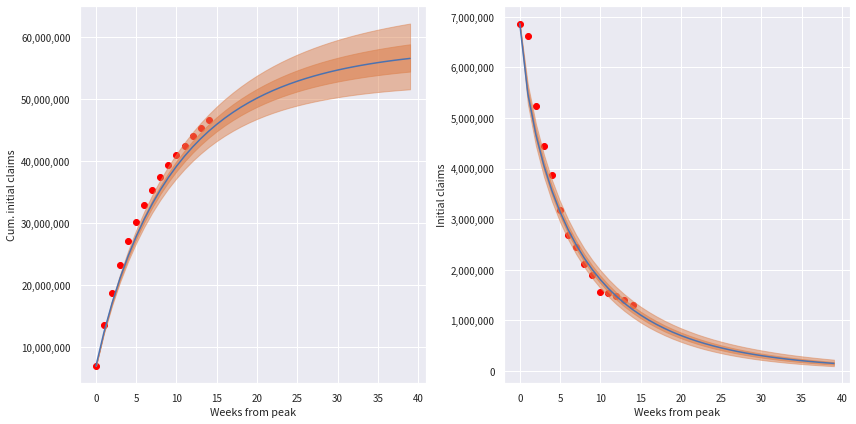

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(ic_pct["period"], ic_pct["50th"].cumsum())
ax[0].scatter(
    data[data.epi_idx==1]["x"], 
    (data[data.epi_idx==1]["y"] * ic_pct.iloc[0, 1]).cumsum(),
    color="red"
)
ax[0].fill_between(
    ic_pct["period"], (ic_pct["25th"]).cumsum(), (ic_pct["75th"]).cumsum(), 
    alpha=0.6, color='C1'
)
ax[0].fill_between(
    ic_pct["period"], ic_pct["5th"].cumsum(), ic_pct["95th"].cumsum(), alpha=0.5,
    color='C1'
)
ax[0].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax[0].set(xlabel='Weeks from peak', ylabel='Cum. initial claims')

ax[1].plot(ic_pct["period"], ic_pct["50th"])
ax[1].scatter(
    data[data.epi_idx==1]["x"], (data[data.epi_idx==1]["y"] * ic_pct.iloc[0, 1]),
    color="red"
)
ax[1].fill_between(
    ic_pct["period"], (ic_pct["25th"]), (ic_pct["75th"]), alpha=0.6, color='C1'
)
ax[1].fill_between(
    ic_pct["period"], ic_pct["5th"], ic_pct["95th"], alpha=0.5,
    color='C1'
)
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax[1].set(xlabel='Weeks from peak', ylabel='Initial claims');

plt.tight_layout()

## Projections

In the Figures above, we present the forecast for the US
over a 13-week horizon. Both weekly and cumulative claim totals
since the start of the episodic peak are presented. 

In [34]:
risk_df = pd.read_excel(
    "https://www.stlouisfed.org/~/media/Files/Excel/articles_spreadsheet_extended.xlsx?la=en"
).iloc[1:, [0, 1, 2, 3]].reset_index(drop=True)
risk_df.rename(
    columns={
        "State": "state", "High Risk Rank": "risk_rank",
        "Total employment": "employment",
        "% Low Risk Employment": "pct_low_risk"
    }, inplace=True)

risk_df["pct_low_risk"] = risk_df["pct_low_risk"].astype(float)/100

In [35]:
def do_one_state(state):
    ''' generates projections for one state '''
    
    x, y, z, idate, end_date = project_claims(state, covid_wt, sum_df, epi_enc)
    xx = pd.concat([x] * 5, axis=1)
    xx.columns =["5th", "25th", "50th", "75th", "95th"]

    xx = pd.concat([xx, z.loc[x.index[-1] + pd.tseries.offsets.Week(1):, ]]).iloc[:, :-2]
    xx = xx.pct_change(periods=52)
    xx["state"] = state
    
    return xx[["state", "50th"]].reset_index().rename(columns={"index": "edate", "50th": "pct_ic"})

In [36]:
%%time 

xy = []
for i in states:
    xy.append(do_one_state(i))
chg_df = pd.concat(xy)

CPU times: user 22.5 s, sys: 118 ms, total: 22.6 s
Wall time: 58.7 s


In [37]:
%%time

sim_dict = {}
cl_fct = []
for i in risk_df.state.to_list() + ["US"]:

    x, y, z, idate, end_date = project_claims(i, covid_wt, sum_df, epi_enc)
    
    pct_low_risk = risk_df[risk_df.state == i]["pct_low_risk"]
    employed = (
        float(risk_df["employment"].sum()) if i == "US" else 
        float(risk_df[risk_df.state == i]["employment"]) 
    )
    peak_date = z.index[0]
    pre_peak_claims = float(x.loc["2020-03-14":peak_date].sum())
    
    zz = (pre_peak_claims + z.iloc[:, :5].cumsum())/employed
    zz.columns = ["pct_" + x for x in z.iloc[:, :5].columns.to_list()]
    
    z = pd.concat([z, zz], axis=1)
    
    sim_dict[i] = {
        "ic_raw": x, "fct_df": y, "ic_pct": z, "peak_date": peak_date, 
        "employed": employed, "pre_peak_claims": pre_peak_claims,
        "pct_low_risk": pct_low_risk
    }
    state_share = y["ic"]
    cl_fct.append(z.iloc[-1, 6:].to_frame().T.reset_index(drop=True))

CPU times: user 20.9 s, sys: 150 ms, total: 21 s
Wall time: 1min 1s


In [38]:
external_files_dir = "/home/gsinha/admin/db/dev/Python/projects/models/data/"
fname = "claims.pkl"
dump_models = True
if dump_models:
    with open(external_files_dir + fname, "wb") as f:
         joblib.dump(
             {
                 "model": ic_model, "trace": trace,
                 "epi_enc": epi_enc, "data": data, 
                 "az_data": az_data, "ppc": ppc,
                 "sum_df": sum_df, "sim_dict": sim_dict,
                 "chg_df": chg_df
             }, f
         )